# 00. Librerías

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sn

# 01. Carga de datos

In [2]:
base_path = 'C:\\Users\\monts\\Practica2\\project'

In [3]:
parquet_file = os.path.join(base_path, "data_procesada", 'df_reducido.parquet')

In [4]:
full_df = pd.read_parquet(parquet_file)

In [5]:
full_df.shape

(3856577, 34)

# 02. EDA inicial

## 02.1. Homologación del tipo de defunción

In [6]:
full_df.columns

Index(['ent_resid', 'mun_resid', 'tloc_resid', 'loc_resid', 'ent_ocurr',
       'mun_ocurr', 'tloc_ocurr', 'loc_ocurr', 'causa_def', 'sexo', 'edad',
       'dia_ocurr', 'mes_ocurr', 'anio_ocur', 'dia_nacim', 'mes_nacim',
       'anio_nacim', 'ocupacion', 'escolarida', 'edo_civil', 'lugar_ocur',
       'necropsia', 'asist_medi', 'sitio_ocur', 'cond_cert', 'derechohab',
       'horas', 'minutos', 'grupo', 'area_ur', 'edad_agru', 'cond_act',
       'tipo_defun', 'year_db'],
      dtype='object')

In [7]:
cont_table = pd.crosstab(index = full_df['tipo_defun'], columns = full_df['year_db'])
cont_table['Total'] = cont_table.sum(axis = 1)

In [8]:
cont_table

year_db,2020,2021,2022,2023,Total
tipo_defun,,,,,
1,32364,34613,37457,40282,144716
2,36773,35700,33291,32253,138017
3,7896,8433,8241,9072,33642
4,5580,5898,762773,715751,1490002
5,47,54,35,29,165
8,1004083,1037551,0,0,2041634
9,0,0,5919,2482,8401


La clasificación de las defunciones es distinta en 2023 y 2024. En general, se tenía:

1: Accidente 

2: Homicidio  

3: Suicidio  

4: Se ignora --> Enfermedad/muerte natural (en 2023)

5: Operaciones legales/guerra 

8: No aplica para muerte natural --> --- 

9: --- --> Se ignora

Para 2023, necesitamos recodificar la categoría 4 --> 8 y 9 --> 4

Con ello se homologan las categorías en todos los años y se elimina la categoría 9

In [9]:
# Mapeo
mapp = {
    4: 8,  # Muerte natural
    9: 4   # Se ignora
}

In [10]:
# Recategorización para 2022
df_2022 = full_df[full_df['year_db']==2022].copy()

In [11]:
df_2022['tipo_defun'].value_counts() # Categorías y distribución original

tipo_defun
4    762773
1     37457
2     33291
3      8241
9      5919
5        35
Name: count, dtype: int64

In [12]:
df_2022['tipo_defun'] = df_2022['tipo_defun'].replace(mapp) # Recategorización
df_2022['tipo_defun'].value_counts() # validación

tipo_defun
8    762773
1     37457
2     33291
3      8241
4      5919
5        35
Name: count, dtype: int64

In [13]:
# Recategorización 2023
df_2023 = full_df[full_df['year_db']==2023].copy()

In [14]:
df_2023['tipo_defun'].value_counts() # Categorías y distribución original

tipo_defun
4    715751
1     40282
2     32253
3      9072
9      2482
5        29
Name: count, dtype: int64

In [15]:
df_2023['tipo_defun'] = df_2023['tipo_defun'].replace(mapp) # Recategorización
df_2023['tipo_defun'].value_counts() # validación

tipo_defun
8    715751
1     40282
2     32253
3      9072
4      2482
5        29
Name: count, dtype: int64

In [16]:
# Reindexación
indices_2022 = df_2022.index
indices_2023 = df_2023.index

In [17]:
# Reemplazamiento
full_df.loc[indices_2022, 'tipo_defun'] = df_2022['tipo_defun']
full_df.loc[indices_2023, 'tipo_defun'] = df_2023['tipo_defun']

In [18]:
# Tabla de contingencia de validación
cont_table = pd.crosstab(index = full_df['tipo_defun'], columns = full_df['year_db'])
cont_table['Total'] = cont_table.sum(axis = 1)
cont_table

year_db,2020,2021,2022,2023,Total
tipo_defun,,,,,
1,32364,34613,37457,40282,144716
2,36773,35700,33291,32253,138017
3,7896,8433,8241,9072,33642
4,5580,5898,5919,2482,19879
5,47,54,35,29,165
8,1004083,1037551,762773,715751,3520158


In [19]:
# Distribución del tipo de defunción por año
percent_table = pd.crosstab(
    index = full_df['tipo_defun'],
    columns = full_df['year_db'],
    normalize = 'columns'  
) * 100 

In [20]:
percent_table.round(2)

year_db,2020,2021,2022,2023
tipo_defun,,,,
1,2.98,3.08,4.42,5.04
2,3.38,3.18,3.93,4.03
3,0.73,0.75,0.97,1.13
4,0.51,0.53,0.70,0.31
5,0.00,0.00,0.00,0.00
8,92.39,92.45,89.98,89.48


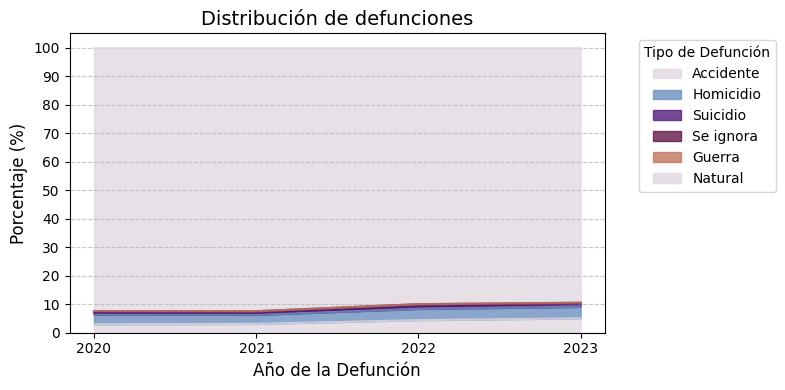

In [21]:
# Visualización 
aux_plot = percent_table.transpose()

dicc_legend = {
    1: 'Accidente',
    2: 'Homicidio',
    3: 'Suicidio',
    4: 'Se ignora',
    5: 'Guerra',
    8: 'Natural'
}

col_names = [dicc_legend.get(col, col) for col in aux_plot.columns]
aux_plot.columns = col_names

fig, ax = plt.subplots(figsize=(8, 4))

num_clases = len(aux_plot.columns)
colores = plt.colormaps['twilight'](np.linspace(0, 1, num_clases))
years = aux_plot.index.astype(int) 

ax.set_xticks(years)

aux_plot.plot.area(
    ax = ax,
    color = colores,
    alpha = 0.8
)

plt.title('Distribución de defunciones', fontsize=14)
plt.xlabel('Año de la Defunción', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)

plt.yticks(np.arange(0, 101, 10)) # Asegura que el eje Y vaya de 0 a 100

plt.legend(
    title='Tipo de Defunción', 
    bbox_to_anchor=(1.05, 1), # Mueve la leyenda fuera del gráfico
    loc='upper left'
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 02.2. Validación de nulos

In [22]:
full_df.columns

Index(['ent_resid', 'mun_resid', 'tloc_resid', 'loc_resid', 'ent_ocurr',
       'mun_ocurr', 'tloc_ocurr', 'loc_ocurr', 'causa_def', 'sexo', 'edad',
       'dia_ocurr', 'mes_ocurr', 'anio_ocur', 'dia_nacim', 'mes_nacim',
       'anio_nacim', 'ocupacion', 'escolarida', 'edo_civil', 'lugar_ocur',
       'necropsia', 'asist_medi', 'sitio_ocur', 'cond_cert', 'derechohab',
       'horas', 'minutos', 'grupo', 'area_ur', 'edad_agru', 'cond_act',
       'tipo_defun', 'year_db'],
      dtype='object')

In [23]:
# Conteo de nulos por columna
count_null = full_df.isnull().sum()
count_null.sum() # sin valores nulos en el df

np.int64(0)

## 02.3. Cálculo de edad

In [24]:
# Revisión de la variable original "edad"
sorted(full_df['edad'].unique())

[np.int64(1001),
 np.int64(1002),
 np.int64(1003),
 np.int64(1004),
 np.int64(1005),
 np.int64(1006),
 np.int64(1007),
 np.int64(1008),
 np.int64(1009),
 np.int64(1010),
 np.int64(1011),
 np.int64(1012),
 np.int64(1013),
 np.int64(1014),
 np.int64(1015),
 np.int64(1016),
 np.int64(1017),
 np.int64(1018),
 np.int64(1019),
 np.int64(1020),
 np.int64(1021),
 np.int64(1022),
 np.int64(1023),
 np.int64(1097),
 np.int64(1098),
 np.int64(2001),
 np.int64(2002),
 np.int64(2003),
 np.int64(2004),
 np.int64(2005),
 np.int64(2006),
 np.int64(2007),
 np.int64(2008),
 np.int64(2009),
 np.int64(2010),
 np.int64(2011),
 np.int64(2012),
 np.int64(2013),
 np.int64(2014),
 np.int64(2015),
 np.int64(2016),
 np.int64(2017),
 np.int64(2018),
 np.int64(2019),
 np.int64(2020),
 np.int64(2021),
 np.int64(2022),
 np.int64(2023),
 np.int64(2024),
 np.int64(2025),
 np.int64(2026),
 np.int64(2027),
 np.int64(2028),
 np.int64(2029),
 np.int64(2098),
 np.int64(3001),
 np.int64(3002),
 np.int64(3003),
 np.int64(3004

Descripción de valores:

1001-1023: horas

1097: minutos

1098: horas no especificadas

2001-2029: días

2098: días no especificados

3001-3011: meses

3098: meses no especificados

4001-4120: años

4998: años no espeecificados

In [25]:
# Reclasifiación
full_df['age'] = np.nan

# Las edades medidas en horas, días y meses se reclasificarán con edad 0 años
cond_menor = (full_df['edad'] >= 1001) & (full_df['edad'] <= 3999)
full_df.loc[cond_menor, 'age'] = 0

# Recodificación para edades de 1 años a 120 años (el estándar de edades)
cond_años = (full_df['edad'] >= 4001) & (full_df['edad'] <= 4120)
full_df.loc[cond_años, 'age'] = full_df['edad'] - 4000

# Los años no especificados se convierten en NaN
full_df.loc[full_df['edad'] == 4998, 'age'] = np.nan

In [26]:
full_df['age'].nunique() # edades únicas

121

In [27]:
full_df['age'].isnull().sum() # nulos actuales

np.int64(20875)

In [28]:
# Cálculo de una nueva variable de edad a partir de las variables de nacimiento y ocurrencia de la defunción
var_dates = ['anio_nacim', 'mes_nacim', 'dia_nacim', 'anio_ocur', 'mes_ocurr', 'dia_ocurr']
min_dates = full_df[var_dates].min()
max_dates = full_df[var_dates].max()

In [29]:
resume_dates = pd.DataFrame({
    'Minimo': min_dates,
    'Maximo': max_dates
})

resume_dates

,Minimo,Maximo
anio_nacim,1897,9999
mes_nacim,1,99
dia_nacim,1,99
anio_ocur,1900,9999
mes_ocurr,1,99
dia_ocurr,1,99


In [30]:
# Revisión de fechas 9999/99
cod_anomalos = {
    'anio_nacim': 9999, 'anio_ocur': 9999,
    'mes_nacim': 99, 'mes_ocurr': 99,
    'dia_nacim': 99, 'dia_ocurr': 99
}

count_anomalos = {}
for var in var_dates:
    codigo = cod_anomalos[var]
    count_anomalos[var] = full_df[full_df[var] == codigo].shape[0]

count_serie = pd.Series(count_anomalos)

count_nacim = count_serie[['anio_nacim', 'mes_nacim', 'dia_nacim']]
count_ocurr = count_serie[['anio_ocur', 'mes_ocurr', 'dia_ocurr']]

In [31]:
print(count_serie)

anio_nacim    45987
mes_nacim     48699
dia_nacim     48839
anio_ocur      1613
mes_ocurr      3012
dia_ocurr      4203
dtype: int64


In [32]:
count_ocurr.nunique() == 1

False

In [33]:
sorted(full_df['anio_nacim'].unique())

[np.int64(1897),
 np.int64(1900),
 np.int64(1901),
 np.int64(1902),
 np.int64(1903),
 np.int64(1904),
 np.int64(1905),
 np.int64(1906),
 np.int64(1907),
 np.int64(1908),
 np.int64(1909),
 np.int64(1910),
 np.int64(1911),
 np.int64(1912),
 np.int64(1913),
 np.int64(1914),
 np.int64(1915),
 np.int64(1916),
 np.int64(1917),
 np.int64(1918),
 np.int64(1919),
 np.int64(1920),
 np.int64(1921),
 np.int64(1922),
 np.int64(1923),
 np.int64(1924),
 np.int64(1925),
 np.int64(1926),
 np.int64(1927),
 np.int64(1928),
 np.int64(1929),
 np.int64(1930),
 np.int64(1931),
 np.int64(1932),
 np.int64(1933),
 np.int64(1934),
 np.int64(1935),
 np.int64(1936),
 np.int64(1937),
 np.int64(1938),
 np.int64(1939),
 np.int64(1940),
 np.int64(1941),
 np.int64(1942),
 np.int64(1943),
 np.int64(1944),
 np.int64(1945),
 np.int64(1946),
 np.int64(1947),
 np.int64(1948),
 np.int64(1949),
 np.int64(1950),
 np.int64(1951),
 np.int64(1952),
 np.int64(1953),
 np.int64(1954),
 np.int64(1955),
 np.int64(1956),
 np.int64(1957

In [34]:
# Fecha de nacimiento
full_df['fecha_nacim'] = pd.to_datetime(
    full_df[['anio_nacim', 'mes_nacim', 'dia_nacim']].rename(columns = {
        'anio_nacim': 'year', 
        'mes_nacim': 'month', 
        'dia_nacim': 'day'
    }), 
    errors='coerce'
)

In [35]:
full_df['fecha_nacim'].isnull().sum()

np.int64(48839)

In [36]:
full_df['fecha_nacim'].dtype

dtype('<M8[ns]')

In [37]:
# Fecha de ocurrencia de la defunción
full_df['fecha_ocurr'] = pd.to_datetime(
    full_df[['anio_ocur', 'mes_ocurr', 'dia_ocurr']].rename(columns = {
        'anio_ocur': 'year', 
        'mes_ocurr': 'month', 
        'dia_ocurr': 'day'
    }), 
    errors='coerce'
)

In [38]:
full_df['fecha_ocurr'].isnull().sum()

np.int64(4203)

In [39]:
full_df['fecha_ocurr'].dtype

dtype('<M8[ns]')

In [40]:
# Días por año
dias_anio = 365.25

In [41]:
dif_dias = (full_df['fecha_ocurr'] - full_df['fecha_nacim']) / np.timedelta64(1, 'D')

In [42]:
full_df['age_manual'] = np.floor(dif_dias / dias_anio)

In [43]:
full_df['age_manual'].isnull().sum()

np.int64(50257)

In [44]:
# Imputación con la edad recodificada
full_df['age_final'] = full_df['age_manual'].fillna(full_df['age'])

full_df['age_final'] = full_df['age_final'].astype('Int64')

In [45]:
full_df['age_final'].isnull().sum()

np.int64(20856)

In [46]:
full_df.shape

(3856577, 39)

full_df.columns

## 02.4. Salida

In [47]:
file_name = 'df_limpio.parquet'
output_path = os.path.join(base_path, 'data_procesada')
parquet_file = os.path.join(output_path, file_name)
full_df.to_parquet(parquet_file, index=False)

# 03. EDA | Ingeniería de variables sobre suicidios

## 03.1. Revisión de la edad

In [48]:
df_suicide = full_df[full_df['tipo_defun'] == 3].copy().reset_index(drop = True)

In [49]:
df_suicide.shape

(33642, 39)

In [50]:
# Revisión de las variables de nacimiento y ocurrencia de la defunción
min_dates_s = df_suicide[var_dates].min()
max_dates_s = df_suicide[var_dates].max()

In [51]:
resume_dates_s = pd.DataFrame({
    'Minimo': min_dates_s,
    'Maximo': max_dates_s
})

resume_dates_s

,Minimo,Maximo
anio_nacim,1916,9999
mes_nacim,1,99
dia_nacim,1,99
anio_ocur,2000,9999
mes_ocurr,1,99
dia_ocurr,1,99


In [52]:
# Revisión de fechas 9999/99
cod_anomalos = {
    'anio_nacim': 9999, 'anio_ocur': 9999,
    'mes_nacim': 99, 'mes_ocurr': 99,
    'dia_nacim': 99, 'dia_ocurr': 99
}

count_anomalos_s = {}
for var in var_dates:
    codigo = cod_anomalos[var]
    count_anomalos_s[var] = df_suicide[df_suicide[var] == codigo].shape[0]

count_serie_s = pd.Series(count_anomalos_s)

count_nacim_s = count_serie_s[['anio_nacim', 'mes_nacim', 'dia_nacim']]
count_ocurr_s = count_serie_s[['anio_ocur', 'mes_ocurr', 'dia_ocurr']]

In [53]:
print(count_serie_s)

anio_nacim    1674
mes_nacim     1701
dia_nacim     1704
anio_ocur       31
mes_ocurr       72
dia_ocurr      142
dtype: int64


In [54]:
df_suicide['age_final'].unique()

<IntegerArray>
[  26,   30,   15,   34,   22,   50,   71,   31,   20,   62,   23,   35,   53,
   60,   56,   28,   27,   38,   42,   14,   48,   18,   43,   51,   25,   44,
   52,   16,   49,   19,   29,   41,   32,   81,   24,   68,   21,   46,   55,
   40,   75,   47,   59,   12,   79,   37, <NA>,   36,   72,   65,   67,   61,
   66,   57,   45,   39,   76,   69,   17,   33,   63,   73,   13,   64,   82,
   54,   58,   74,   80,   70,   90,   85,   77,   89,   11,   87,   86,   10,
   84,   78,   88,    8,  101,  100,   83,   92,   93,   95,   91,   94,   96,
    9,    0,   99,  105,   98]
Length: 96, dtype: Int64

In [55]:
# Valida-Fecha
diff_edad = (df_suicide['age_final'] - df_suicide['age']).abs() == 1

In [56]:
diff_edad.sum() # Esta diferencia se da por la estimación que usamos de 365.25

np.int64(56)

In [57]:
# Para estos 56 casos nos quedaremos con las edades de la bd (para mayor precisión)
df_suicide.loc[diff_edad, 'age_final'] = df_suicide.loc[diff_edad, 'age']

In [58]:
df_suicide['age_final'].isnull().sum()

np.int64(325)

In [59]:
dif_edad = (df_suicide['age_final'] - df_suicide['age']).abs() 

In [60]:
dif_edad.value_counts()

0.0     33308
20.0        5
31.0        3
38.0        1
Name: count, dtype: Int64

In [61]:
# Revisión de casos con diferencia
filter_dif = dif_edad.abs().isin([20.0, 31.0, 38.0])

rev_df = df_suicide.loc[filter_dif, [
    'age', 'age_final', 'edad_agru',
    'fecha_nacim', 'fecha_ocurr',
    'grupo', 'causa_def' # Columna clave para validar el suicidio
]].copy()

In [62]:
rev_df

,age,age_final,edad_agru,fecha_nacim,fecha_ocurr,grupo,causa_def
10367,20.0,0,9,2022-02-16,2022-05-07,26,X700
10582,20.0,0,9,2022-05-09,2022-08-01,26,X700
13617,20.0,0,9,2022-04-27,2022-09-16,26,X700
20562,31.0,0,11,2021-04-04,2021-10-28,26,X700
23804,20.0,0,9,2021-11-06,2021-12-02,26,X708
25251,20.0,0,9,2021-02-16,2021-10-07,26,X700
28650,38.0,0,12,2020-04-26,2020-04-30,26,X708
31011,31.0,0,11,2020-07-01,2020-09-17,26,X700
32482,31.0,0,11,2020-07-23,2020-09-07,26,X700


In [63]:
((df_suicide['age_final'].isnull().sum() + len(rev_df))/len(df_suicide)).round(4)

np.float64(0.0099)

En estos casos, la edad calculada es correcta; sin embargo, no tiene sentido un suicidio en bebés.
Para estos casos y los 325 casos en donde la edad es NULL derivado de que tanto la edad original como las fechas para calcularla son desconocidas, la estrategia será imputarles la mediana de las edades.
Es importante imputar porque la variable es crucial en el análisis y para el clustering es mejor no tener valores nulos, utilizamos la mediana para mayor practicidad y porque no se ve influenciado por valores extremos. Además, el % de imputación será sólo un 1%

In [64]:
# Filtro sin NA y sin los 9 casos anómalos para cálculo de la mediana
filter_edad = (df_suicide['age_final'].notna()) & (df_suicide['age_final'] > 0)
filter_edad.sum()

np.int64(33308)

In [65]:
median_age = df_suicide.loc[filter_edad, 'age_final'].median()
median_age

np.float64(32.0)

In [66]:
# Identificación de casos para imputación
filter_nulls = df_suicide['age_final'].isnull()
filter_nulls.shape

(33642,)

In [67]:
filter_nulls.sum()

np.int64(325)

In [68]:
anomal_age = (df_suicide['age_final'] == 0) & (df_suicide['age'] > 0)

In [69]:
anomal_age.sum()

np.int64(9)

In [70]:
index_imputacion = filter_nulls | anomal_age

In [71]:
index_imputacion.sum()

np.int64(334)

In [72]:
print(df_suicide['age_final'].value_counts())

age_final
25     1053
27     1013
26     1006
28     1000
22      984
       ... 
100       2
95        1
101       1
105       1
98        1
Name: count, Length: 95, dtype: Int64


In [73]:
# Imputación de la mediana
df_suicide.loc[index_imputacion, 'age_final'] = median_age
df_suicide['age_final'] = df_suicide['age_final'].astype('Int64')

In [74]:
df_suicide['age_final'].isnull().sum()

np.int64(0)

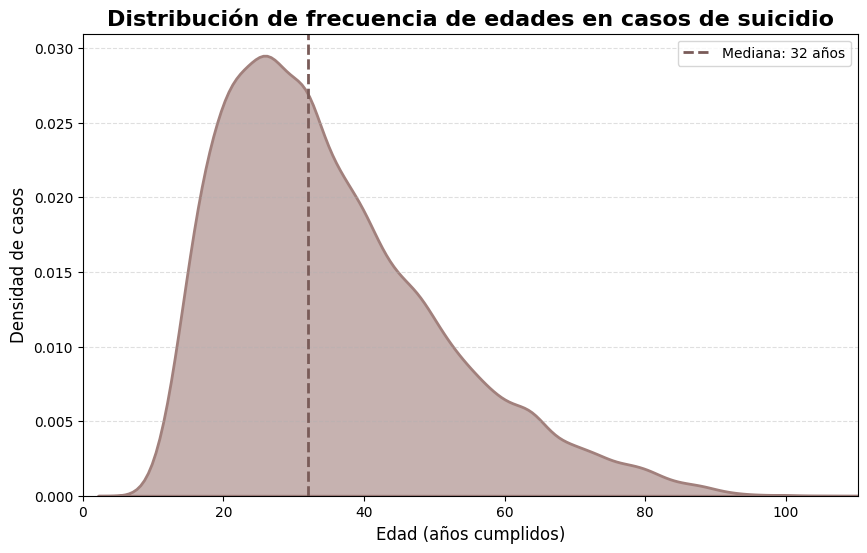

In [75]:
# Visualización
plt.figure(figsize=(10, 6))

# Densidad
sn.kdeplot(
    data=df_suicide, 
    x='age_final', 
    fill=True, 
    color='#A1807C', 
    alpha=.6, 
    linewidth=2
)

# Identificación de la mediana como referencia
mediana = df_suicide['age_final'].median()
plt.axvline(
    mediana, 
    color='#795B58', 
    linestyle='--', 
    linewidth=2, 
    label=f'Mediana: {mediana:.0f} años'
)

# Featuring
plt.title('Distribución de frecuencia de edades en casos de suicidio', fontsize=16, weight='bold')
plt.xlabel('Edad (años cumplidos)', fontsize=12)
plt.ylabel('Densidad de casos', fontsize=12)
plt.xlim(0, df_suicide['age_final'].max() * 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend()
plt.show()

## 03.2. Revisión del género

In [76]:
df_suicide.columns

Index(['ent_resid', 'mun_resid', 'tloc_resid', 'loc_resid', 'ent_ocurr',
       'mun_ocurr', 'tloc_ocurr', 'loc_ocurr', 'causa_def', 'sexo', 'edad',
       'dia_ocurr', 'mes_ocurr', 'anio_ocur', 'dia_nacim', 'mes_nacim',
       'anio_nacim', 'ocupacion', 'escolarida', 'edo_civil', 'lugar_ocur',
       'necropsia', 'asist_medi', 'sitio_ocur', 'cond_cert', 'derechohab',
       'horas', 'minutos', 'grupo', 'area_ur', 'edad_agru', 'cond_act',
       'tipo_defun', 'year_db', 'age', 'fecha_nacim', 'fecha_ocurr',
       'age_manual', 'age_final'],
      dtype='object')

In [77]:
df_suicide['sexo'].value_counts(1)

sexo
1    0.812140
2    0.187058
9    0.000803
Name: proportion, dtype: float64

La categoría 9 está asociada al sexo **No Especificado**. Dado que la categoría dominante es 1:hombre, se optará por reclasificar estas casos como 1, lo cual representa un menor impacto en el sesgo.

In [78]:
df_suicide.loc[df_suicide['sexo'] == 9, 'sexo'] = 1
df_suicide['sexo'] = df_suicide['sexo'].fillna(1)

In [79]:
# Nueva distribución
df_suicide['sexo'].value_counts(1)

sexo
1    0.812942
2    0.187058
Name: proportion, dtype: float64

In [80]:
# Decodoficación del sexo
df_suicide['sexo'] = df_suicide['sexo'].map({1: 'Hombre', 2: 'Mujer'})

In [81]:
# Cálculo de la mediana por género, como referencia 
median_gender = df_suicide.groupby('sexo')['age_final'].median()

median_man = median_gender['Hombre']
median_women = median_gender['Mujer']

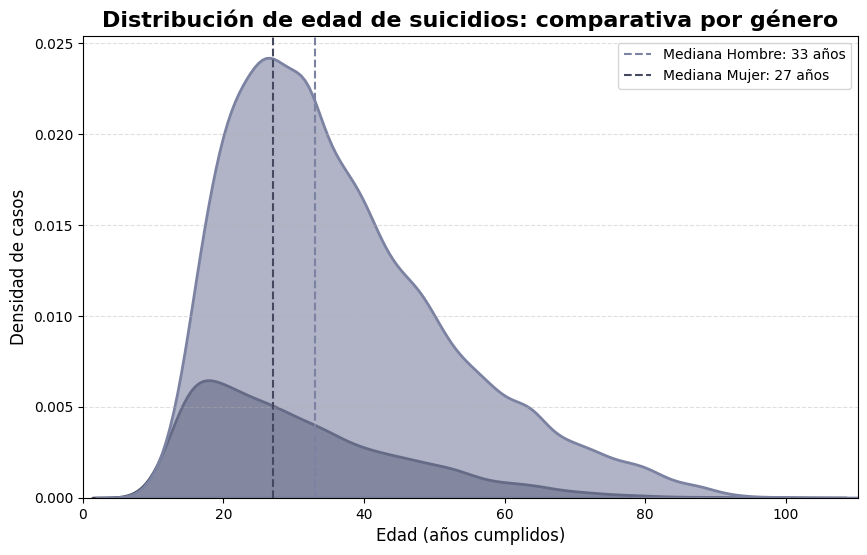

In [82]:
# Visualización
plt.figure(figsize=(10, 6))

# Densidades por género
sn.kdeplot(
    data=df_suicide, 
    x='age_final', 
    hue='sexo', 
    fill=True, 
    alpha=.6, 
    linewidth=2,
    palette={'Hombre': '#7C82A1', 'Mujer': '#45495F'}
)

# Mediana hombre
plt.axvline(
    median_man, 
    color='#7C82A1', 
    linestyle='--', 
    linewidth=1.5, 
    label=f'Mediana Hombre: {median_man:.0f} años'
)

# Mediana mujer
plt.axvline(
    median_women, 
    color='#45495F', 
    linestyle='--', 
    linewidth=1.5, 
    label=f'Mediana Mujer: {median_women:.0f} años'
)

plt.title('Distribución de edad de suicidios: comparativa por género', fontsize=16, weight='bold')
plt.xlabel('Edad (años cumplidos)', fontsize=12)
plt.ylabel('Densidad de casos', fontsize=12)
plt.xlim(0, df_suicide['age_final'].max() * 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend() 
plt.show()

## 03.3. Revisión del estado civil

In [83]:
df_suicide['edo_civil'].value_counts()

edo_civil
1    16069
5     7019
4     6119
9     2323
2      807
3      582
6      578
8      145
Name: count, dtype: int64

In [84]:
cont_table_civil = pd.crosstab(index = df_suicide['edo_civil'], columns = df_suicide['year_db'])
cont_table_civil['Total'] = cont_table_civil.sum(axis = 1)

In [85]:
cont_table_civil

year_db,2020,2021,2022,2023,Total
edo_civil,,,,,
1,3701,3914,3917,4537,16069
2,195,192,211,209,807
3,131,163,140,148,582
4,1455,1521,1494,1649,6119
5,1677,1857,1741,1744,7019
6,131,146,126,175,578
8,46,34,35,30,145
9,560,606,577,580,2323


In [86]:
cont_table_civil_perc = pd.crosstab(index = df_suicide['edo_civil'], columns = df_suicide['year_db'], normalize='columns')
cont_table_civil_perc = (cont_table_civil_perc * 100).round(2)

In [87]:
cont_table_civil_perc

year_db,2020,2021,2022,2023
edo_civil,,,,
1,46.87,46.41,47.53,50.01
2,2.47,2.28,2.56,2.30
3,1.66,1.93,1.70,1.63
4,18.43,18.04,18.13,18.18
5,21.24,22.02,21.13,19.22
6,1.66,1.73,1.53,1.93
8,0.58,0.40,0.42,0.33
9,7.09,7.19,7.00,6.39


In [88]:
# Revisión de categoría 8: No aplica para menores de 12 años
df_rev_civil = df_suicide[df_suicide['edo_civil'] == 8].copy()

In [89]:
len(df_rev_civil)

145

In [90]:
# Casos con edad menor a 12
df_rev_civil[df_rev_civil['age_final'] < 12].shape[0]

145

In [91]:
len(df_suicide[df_suicide['age_final']<12]) # En efecto, hay 145 casos con edad menor a 12 años.

145

In [92]:
# Reclasificación de la categoría 8:1
df_suicide.loc[df_suicide['edo_civil'] == 8, 'edo_civil'] = 1

In [93]:
cont_table_civil_perc = pd.crosstab(index = df_suicide['edo_civil'], columns = df_suicide['year_db'], normalize='columns')
cont_table_civil_perc = (cont_table_civil_perc * 100).round(2)

In [94]:
cont_table_civil_perc

year_db,2020,2021,2022,2023
edo_civil,,,,
1,47.45,46.82,47.96,50.34
2,2.47,2.28,2.56,2.30
3,1.66,1.93,1.70,1.63
4,18.43,18.04,18.13,18.18
5,21.24,22.02,21.13,19.22
6,1.66,1.73,1.53,1.93
9,7.09,7.19,7.00,6.39


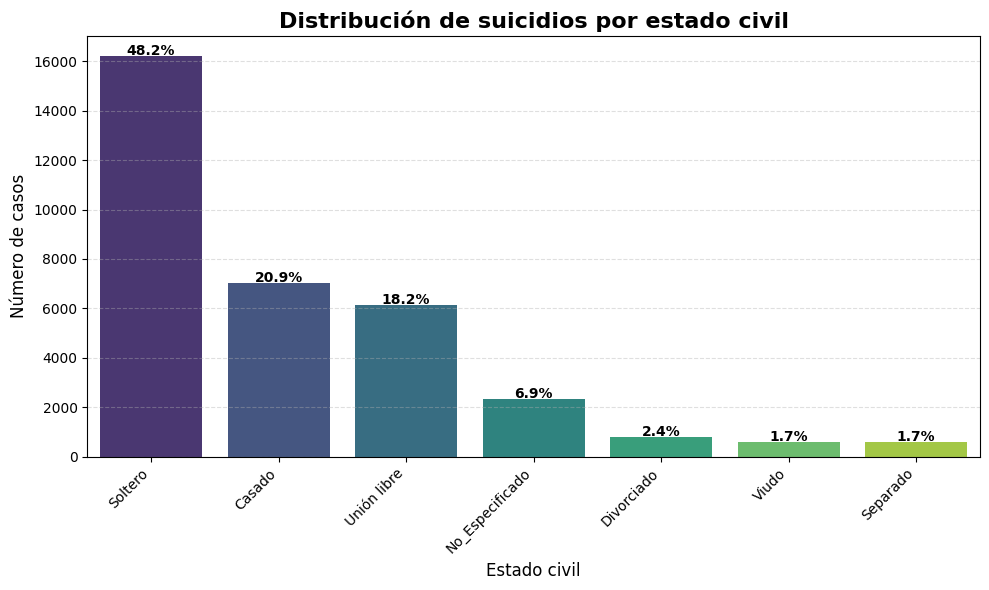

In [95]:
# Visualización
conteo_edo_civil = df_suicide['edo_civil'].value_counts().reset_index()
conteo_edo_civil.columns = ['Estado_Civil', 'Conteo']

conteo_edo_civil = conteo_edo_civil.sort_values(by='Conteo', ascending=False)

# Distribución porcentual general
total_casos = df_suicide.shape[0]

conteo_edo_civil['Proporcion'] = conteo_edo_civil['Conteo'] / total_casos
conteo_edo_civil['Porcentaje'] = (conteo_edo_civil['Proporcion'] * 100).round(1) 

# Remapeo de categorías
mapeo_edo_civil = {
    1: 'Soltero',       # Incluye Soltero original y los casos de Código 8
    2: 'Divorciado',
    3: 'Viudo',
    4: 'Unión libre',
    5: 'Casado',
    6: 'Separado',
    9: 'No_Especificado' 
}

conteo_edo_civil['Estado_Civil'] = conteo_edo_civil['Estado_Civil'].map(mapeo_edo_civil)

plt.figure(figsize=(10, 6))

# Gráfico de barras
ax = sn.barplot(
    data=conteo_edo_civil, 
    x='Estado_Civil', 
    y='Conteo', 
    hue = 'Estado_Civil',
    palette='viridis',
    legend = False
)

# Etiquetas
for index, row in conteo_edo_civil.iterrows():
    ax.text(
        index, 
        row['Conteo'] + 50, 
        f"{row['Porcentaje']}%", 
        color='black', 
        ha="center",     
        fontsize=10,
        weight='bold'
    )

# Featuring
plt.title('Distribución de suicidios por estado civil', fontsize=16, weight='bold')
plt.xlabel('Estado civil', fontsize=12)
plt.ylabel('Número de casos', fontsize=12)
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout() 

plt.show()

## 03.4. Revisión de derechohab

In [96]:
df_suicide['derechohab'].value_counts(1)

derechohab
1     0.465163
99    0.272784
2     0.178854
7     0.042269
3     0.019797
8     0.012811
9     0.003091
5     0.002616
4     0.001367
6     0.000654
10    0.000594
Name: proportion, dtype: float64

In [97]:
# Reclasificación: 1 -> No afiliado | 99 -> No especificado | Resto -> Afiliado
def agrup_derechohab(code):
    if code == 1:
        return 'No Afiliado'
    elif code == 99:
        return 'No Especificado'
    else:
        return 'Afiliado'

In [98]:
df_suicide['derechohab_agrup'] = df_suicide['derechohab'].apply(agrup_derechohab)

# Validación
print("Distribución final de drechohabiencia:")
print(df_suicide['derechohab_agrup'].value_counts(normalize=True).round(3) * 100)

Distribución final de drechohabiencia:
derechohab_agrup
No Afiliado        46.5
No Especificado    27.3
Afiliado           26.2
Name: proportion, dtype: float64


In [99]:
# Estructuración para la visualización
# Conteo por categoría
conteo_derechohab = df_suicide['derechohab_agrup'].value_counts().reset_index()
conteo_derechohab.columns = ['Derechohabiencia', 'Conteo']

# Distribución porcentual
conteo_derechohab['Porcentaje'] = (conteo_derechohab['Conteo'] / total_casos * 100).round(1)

# Reordenamiento
orden_cat = ['No Afiliado', 'No Especificado', 'Afiliado']
conteo_derechohab['Derechohabiencia'] = pd.Categorical(conteo_derechohab['Derechohabiencia'], categories=orden_cat, ordered=True)
conteo_derechohab = conteo_derechohab.sort_values('Derechohabiencia')

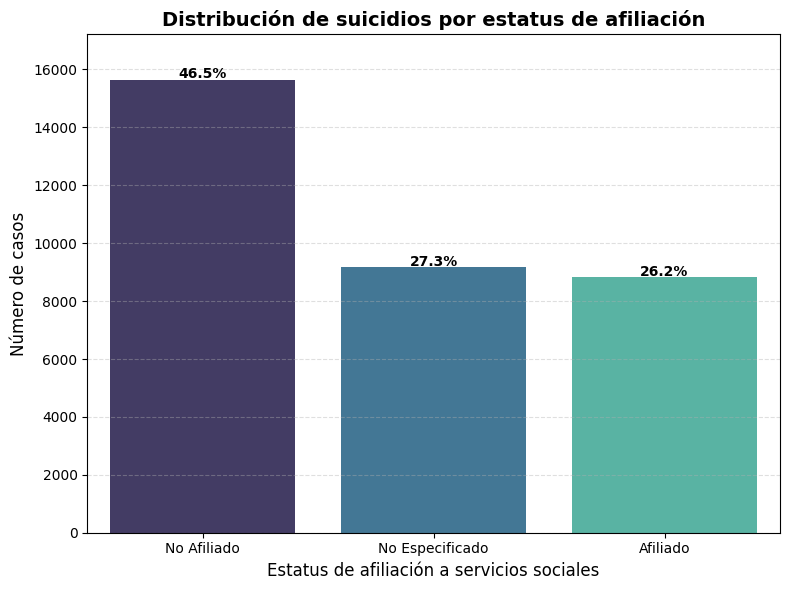

In [100]:
# Visualización 
plt.figure(figsize=(8, 6))

# Gráfico de Barras
ax = sn.barplot(
    data=conteo_derechohab, 
    x='Derechohabiencia', 
    y='Conteo', 
    hue='Derechohabiencia', 
    palette='mako',
    legend=False
)

# Etiquetas
for index, row in conteo_derechohab.iterrows():
    ax.text(
        index, 
        row['Conteo'] + 50, 
        f"{row['Porcentaje']}%", 
        color='black', 
        ha="center",       
        fontsize=10,
        weight='bold'
    )

# Featuring
plt.title('Distribución de suicidios por estatus de afiliación', fontsize=14, weight='bold')
plt.xlabel('Estatus de afiliación a servicios sociales', fontsize=12)
plt.ylabel('Número de casos', fontsize=12)
plt.xticks(rotation=0, ha='center') 
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.ylim(0, conteo_derechohab['Conteo'].max() * 1.1) 
plt.tight_layout()
plt.show()

## 03.5. Revisión de causa_def

In [101]:
df_suicide['causa_def'].unique()

array(['X709', 'X700', 'X780', 'X704', 'X805', 'X708', 'X849', 'X689',
       'X740', 'X841', 'X749', 'X730', 'X649', 'X619', 'X848', 'X705',
       'X804', 'X718', 'X748', 'X699', 'X720', 'X809', 'X694', 'X690',
       'X702', 'X707', 'X701', 'X724', 'X788', 'X789', 'X744', 'X706',
       'X703', 'X786', 'X698', 'X697', 'X610', 'X824', 'X784', 'X640',
       'X800', 'X680', 'X684', 'X688', 'X600', 'X670', 'X729', 'X783',
       'X747', 'X647', 'X687', 'X760', 'X764', 'X745', 'X642', 'X654',
       'X645', 'X828', 'X840', 'X660', 'X844', 'X808', 'X746', 'X815',
       'X845', 'X842', 'X710', 'X644', 'X818', 'X714', 'X681', 'X659',
       'X719', 'X787', 'X650', 'X695', 'X648', 'X691', 'X830', 'X696',
       'X664', 'X802', 'X742', 'X834', 'X769', 'X819', 'X620', 'X781',
       'X629', 'X785', 'X668', 'X843', 'X618', 'X624', 'X669', 'X737',
       'X727', 'X839', 'X829', 'X814', 'X728', 'X741', 'X847', 'X641',
       'X810', 'X679', 'Y870', 'X846', 'X685', 'X615', 'X639', 'X801',
      

In [102]:
# Buscando la reducción de cardinalidad
df_suicide['causa_def_reduc'] = df_suicide['causa_def'].astype(str)
df_suicide['metodo_suicidio'] = df_suicide['causa_def_reduc'].str[:3] # Evitando tanta especificación

In [103]:
code_agrup = df_suicide['metodo_suicidio'].unique()
print("Códigos de método de suicidio agrupados (X60-X83):")
print(sorted(code_agrup))

Códigos de método de suicidio agrupados (X60-X83):
['X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'Y87']


In [104]:
dist_metodos = df_suicide['metodo_suicidio'].value_counts(normalize=True).mul(100).round(1).reset_index()
dist_metodos.columns = ['Codigo_CIE', 'Porcentaje']
print(dist_metodos)

   Codigo_CIE  Porcentaje
0         X70        85.0
1         X74         5.8
2         X69         2.0
3         X68         1.9
4         X78         1.3
5         X84         1.2
6         X64         0.7
7         X80         0.7
8         X61         0.3
9         X71         0.2
10        X76         0.1
11        X67         0.1
12        X73         0.1
13        X72         0.1
14        X81         0.1
15        X83         0.1
16        X82         0.1
17        X66         0.0
18        X65         0.0
19        X62         0.0
20        X60         0.0
21        Y87         0.0
22        X63         0.0
23        X79         0.0
24        X75         0.0


In [105]:
# Reclasificación en 3 ategorías:
def agrup_metodo(code):
    if code == 'X70':
        return 'Ahorcamiento'
    else:
        return 'Otros_Metodos'# Esto incluye X60-X69 (Veneno), X78 (Objetos punzocortantes), X84 (Sin especificar), etc.

df_suicide['metodo_suicidio'] = df_suicide['metodo_suicidio'].apply(agrup_metodo)

# Validación
print("Distribución de métodos de suicidio:")
print(df_suicide['metodo_suicidio'].value_counts(normalize=True).round(3) * 100)

Distribución de métodos de suicidio:
metodo_suicidio
Ahorcamiento     85.0
Otros_Metodos    15.0
Name: proportion, dtype: float64


In [106]:
# Configuración para visualización
conteo_metodo = df_suicide['metodo_suicidio'].value_counts().reset_index()
conteo_metodo.columns = ['Metodo', 'Conteo']

conteo_metodo['Porcentaje'] = (conteo_metodo['Conteo'] / total_casos * 100).round(1)

# Reordenamiento
conteo_metodo = conteo_metodo.sort_values(by='Conteo', ascending=False)

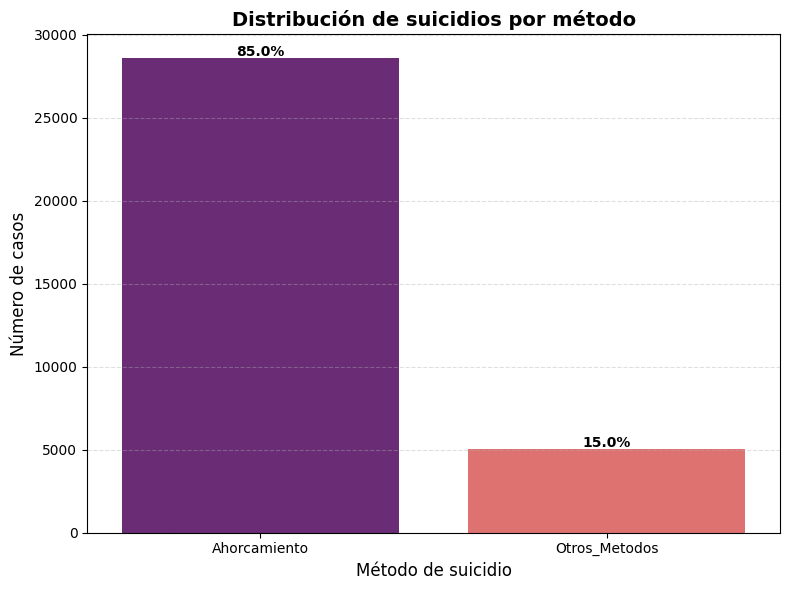

In [107]:
# Visualización
plt.figure(figsize=(8, 6))

# Gráfico de Barras
ax = sn.barplot(
    data=conteo_metodo, 
    x='Metodo', 
    y='Conteo', 
    hue='Metodo', 
    palette='magma', 
    legend=False
)

# Etiquetas porcentuales
for index, row in conteo_metodo.iterrows():
    ax.text(
        index, 
        row['Conteo'] + 100, 
        f"{row['Porcentaje']}%", 
        color='black', 
        ha="center",       
        fontsize=10,
        weight='bold'
    )

# Personalización
plt.title('Distribución de suicidios por método', fontsize=14, weight='bold')
plt.xlabel('Método de suicidio', fontsize=12)
plt.ylabel('Número de casos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.ylim(0, conteo_metodo['Conteo'].max() * 1.05) 
plt.tight_layout()
plt.show()

## 03.6. Revisión de area_ur

In [108]:
df_suicide['area_ur'].value_counts(1)

area_ur
1    0.80780
2    0.16417
9    0.02803
Name: proportion, dtype: float64

Dado que la categoría 9:No especificado representa sólo el 2.8%, para evitar generar ruido en el modelo, se reclasificará como 1 (urbana) al ser éste valor la moda de la distribución

In [109]:
# Imputación
df_suicide.loc[df_suicide['area_ur'] == 9, 'area_ur'] = 1

# Remapeo
mapeo_area = {
    1: 'Urbana',
    2: 'Rural'
}
df_suicide['area_urbana'] = df_suicide['area_ur'].map(mapeo_area)

# Distribución 
print("Distribución del tipo de residencia habitual:")
print(df_suicide['area_urbana'].value_counts(normalize=True).round(3) * 100)

Distribución del tipo de residencia habitual:
area_urbana
Urbana    83.6
Rural     16.4
Name: proportion, dtype: float64


In [110]:
# Configuración para visualización
conteo_area = df_suicide['area_urbana'].value_counts().reset_index()
conteo_area.columns = ['Area', 'Conteo']

# Distribución porcentual
conteo_area['Porcentaje'] = (conteo_area['Conteo'] / total_casos * 100).round(1)

# Labels
labels = conteo_area['Area']
sizes = conteo_area['Conteo']

# Etiquetas
porcentajes_labels = [f'{label} ({size}%)' for label, size in zip(labels, conteo_area['Porcentaje'])]

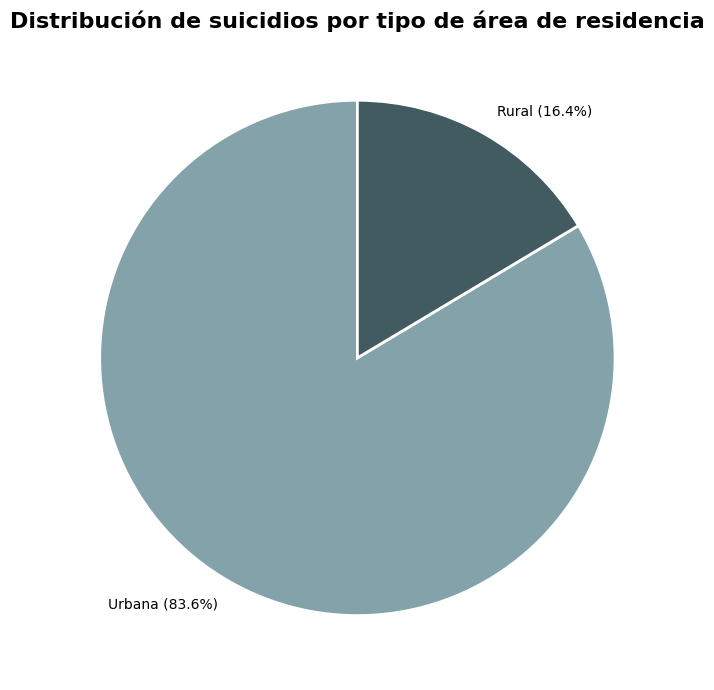

In [111]:
# Visualización
plt.figure(figsize=(7, 7))

plt.pie(
    sizes, 
    labels=porcentajes_labels,
    colors=['#83A2AA', '#425B61'], 
    autopct='',
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}
)

plt.title('Distribución de suicidios por tipo de área de residencia', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

## 03.7. Revisión de lugar_ocur

In [112]:
df_suicide['lugar_ocur'].value_counts(1)

lugar_ocur
0    0.697818
9    0.107960
8    0.083051
4    0.059212
7    0.024166
5    0.009363
1    0.009185
6    0.004251
2    0.003240
3    0.001754
Name: proportion, dtype: float64

In [113]:
# Reducción de cardinalidad
codigos_residuales = [1, 2, 3, 4, 5, 6, 7, 8] # lugares varios

# Reclasificación
def agrup_lugar_ocurr(code):
    if code == 0:
        return 'Vivienda'
    elif code == 9:
        return 'No_Especificado'
    else:
        return 'Otro lugar'

df_suicide['lugar_ocurrencia'] = df_suicide['lugar_ocur'].apply(agrup_lugar_ocurr)

# Validación
print("Distribución del lugar de ocurrencia:")
print(df_suicide['lugar_ocurrencia'].value_counts(normalize=True).mul(100).round(1))

Distribución del lugar de ocurrencia:
lugar_ocurrencia
Vivienda           69.8
Otro lugar         19.4
No_Especificado    10.8
Name: proportion, dtype: float64


In [114]:
# Configuración para visualización
conteo_lugar_ocurr = df_suicide['lugar_ocurrencia'].value_counts().reset_index()
conteo_lugar_ocurr.columns = ['Lugar', 'Conteo']

# Distribución porcentual
conteo_lugar_ocurr['Porcentaje'] = (conteo_lugar_ocurr['Conteo'] / total_casos * 100).round(1)

# Reordenamiento
orden_lugar = ['Vivienda', 'Otro lugar', 'No_Especificado']
conteo_lugar_ocurr['Lugar'] = pd.Categorical(conteo_lugar_ocurr['Lugar'], categories=orden_lugar, ordered=True)
conteo_lugar_ocurr = conteo_lugar_ocurr.sort_values('Lugar')

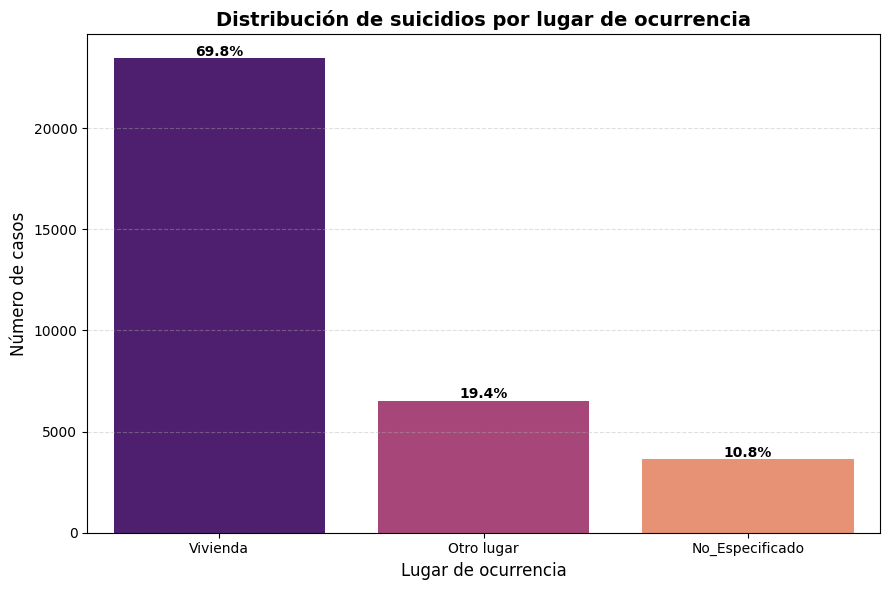

In [115]:
# Visualización
plt.figure(figsize=(9, 6))

# Gráfico de Barras
ax = sn.barplot(
    data=conteo_lugar_ocurr, 
    x='Lugar', 
    y='Conteo', 
    hue='Lugar', 
    palette='magma',
    legend=False
)

# Etiquetas
for index, row in conteo_lugar_ocurr.iterrows():
    ax.text(
        index, 
        row['Conteo'] + 100, 
        f"{row['Porcentaje']}%", 
        color='black', 
        ha="center",       
        fontsize=10,
        weight='bold'
    )

# Personalización
plt.title('Distribución de suicidios por lugar de ocurrencia', fontsize=14, weight='bold')
plt.xlabel('Lugar de ocurrencia', fontsize=12)
plt.ylabel('Número de casos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.ylim(0, conteo_lugar_ocurr['Conteo'].max() * 1.05) 
plt.tight_layout()
plt.show()

## 03.8. Revisión del sitio de ocurrencia

In [116]:
df_suicide['sitio_ocur'].value_counts(1)

sitio_ocur
11    0.631532
12    0.154420
99    0.074282
10    0.062868
1     0.035075
3     0.019440
9     0.008650
8     0.007996
4     0.003091
2     0.002110
5     0.000297
6     0.000178
7     0.000059
Name: proportion, dtype: float64

In [117]:
# Reducción de cardinalidad
code_unidad_medica = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Recodificación
def agrup_sitio_ocur(code):
    if code == 11:
        return 'Hogar'
    elif code == 10:
        return 'Via_publica'
    elif code in code_unidad_medica:
        return 'Unidad_medica'
    else:
        # Por si existe algún otro valor
        return 'No_especificado'

df_suicide['sitio_ocurrencia'] = df_suicide['sitio_ocur'].apply(agrup_sitio_ocur)

# Validación
print("Distribución del sitio de ocurrencia:")
print(df_suicide['sitio_ocurrencia'].value_counts(normalize=True).mul(100).round(1))

Distribución del sitio de ocurrencia:
sitio_ocurrencia
Hogar              63.2
No_especificado    22.9
Unidad_medica       7.7
Via_publica         6.3
Name: proportion, dtype: float64


In [118]:
# Configuración para visualización
conteo_sitio_ocurr = df_suicide['sitio_ocurrencia'].value_counts().reset_index()
conteo_sitio_ocurr.columns = ['Sitio', 'Conteo']

# Distribución porcentual
conteo_sitio_ocurr['Porcentaje'] = (conteo_sitio_ocurr['Conteo'] / total_casos * 100).round(1)

# Reordenamiento
orden_sitio = ['Hogar', 'No_especificado', 'Unidad_medica', 'Via_publica']
conteo_sitio_ocurr['Sitio'] = pd.Categorical(conteo_sitio_ocurr['Sitio'], categories=orden_sitio, ordered=True)
conteo_sitio_ocurr = conteo_sitio_ocurr.sort_values('Sitio')

In [119]:
conteo_sitio_ocurr

,Sitio,Conteo,Porcentaje
0,Hogar,21246,63.2
1,No_especificado,7694,22.9
2,Unidad_medica,2587,7.7
3,Via_publica,2115,6.3


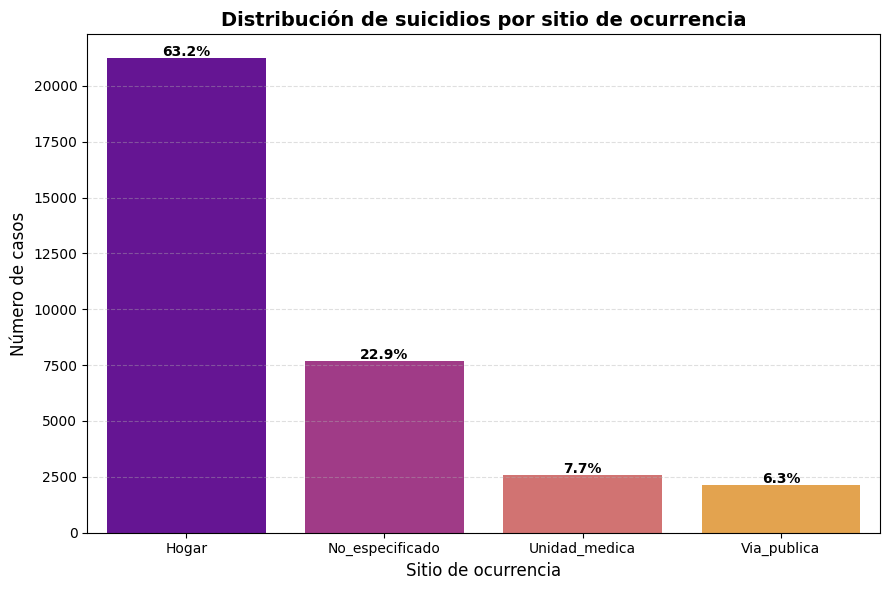

In [120]:
# Visualización
plt.figure(figsize=(9, 6))

# Gráfico de Barras
ax = sn.barplot(
    data=conteo_sitio_ocurr, 
    x='Sitio', 
    y='Conteo', 
    hue='Sitio', 
    palette='plasma', 
    legend=False
)

# Etiquetas
for index, row in conteo_sitio_ocurr.iterrows():
    ax.text(
        index, 
        row['Conteo'] + 100, 
        f"{row['Porcentaje']}%", 
        color='black', 
        ha="center",       
        fontsize=10,
        weight='bold'
    )

# Personalización
plt.title('Distribución de suicidios por sitio de ocurrencia', fontsize=14, weight='bold')
plt.xlabel('Sitio de ocurrencia', fontsize=12)
plt.ylabel('Número de casos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.ylim(0, conteo_sitio_ocurr['Conteo'].max() * 1.05) 
plt.tight_layout()
plt.show()

## 03.9. Revisión escolaridad

In [121]:
df_suicide['escolarida'].value_counts(1)

escolarida
6     0.262678
4     0.176565
8     0.121842
9     0.100143
3     0.093663
5     0.079692
7     0.076363
99    0.047411
1     0.035640
10    0.004964
2     0.001040
Name: proportion, dtype: float64

In [122]:
# Reducción de dimensionalidad
map_escolaridad = {
    # Educación Básica
    1: 'Basica', 2: 'Basica', 3: 'Basica', 4: 'Basica', 5: 'Basica',
    
    # Educación Media
    6: 'Media', 7: 'Media', 8: 'Media',
    
    # Educación Superior
    9: 'Superior', 10: 'Superior',
    
    # No especificado
    99: 'No_Especificado'
}

# Reclasificación
df_suicide['escolaridad_agrup'] = df_suicide['escolarida'].map(map_escolaridad)

# Validación
print("Distribución de suicidios por nivel educativo:")
print(df_suicide['escolaridad_agrup'].value_counts(normalize=True).mul(100).round(1))

Distribución de suicidios por nivel educativo:
escolaridad_agrup
Media              46.1
Basica             38.7
Superior           10.5
No_Especificado     4.7
Name: proportion, dtype: float64


In [123]:
# Configuración para la visualización
conteo_escolaridad = df_suicide['escolaridad_agrup'].value_counts().reset_index()
conteo_escolaridad.columns = ['Nivel_Educativo', 'Conteo']

conteo_escolaridad['Porcentaje'] = (conteo_escolaridad['Conteo'] / total_casos * 100).round(1)

# Reordenamiento
orden_esc = ['Media', 'Basica', 'Superior', 'No_Especificado']
conteo_escolaridad['Nivel_Educativo'] = pd.Categorical(conteo_escolaridad['Nivel_Educativo'], categories=orden_esc, ordered=True)
conteo_escolaridad = conteo_escolaridad.sort_values('Nivel_Educativo')

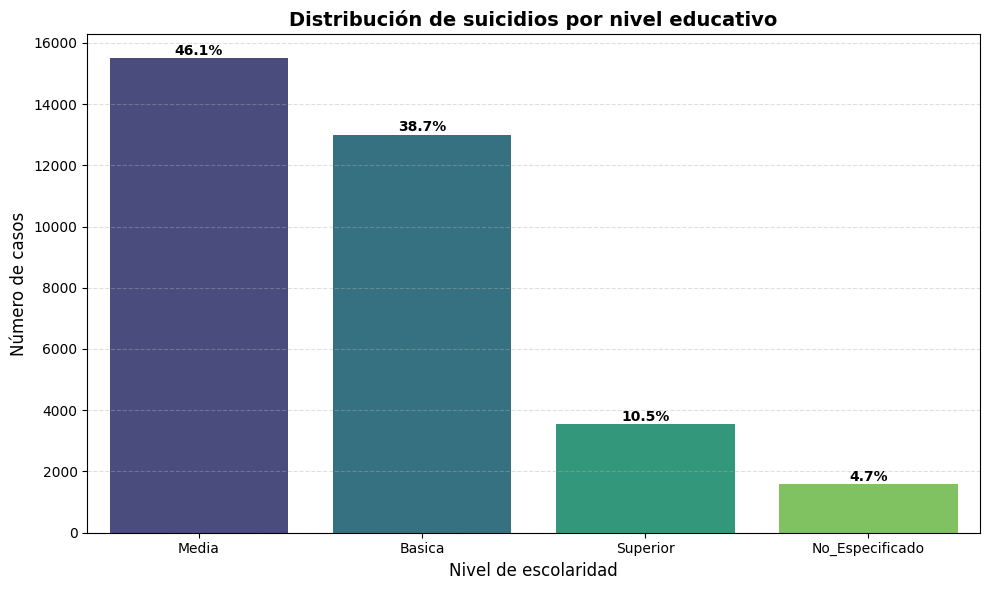

In [124]:
# Visualización
plt.figure(figsize=(10, 6))

# Gráfico de Barras
ax = sn.barplot(
    data=conteo_escolaridad, 
    x='Nivel_Educativo', 
    y='Conteo', 
    hue='Nivel_Educativo', 
    palette='viridis', 
    legend=False
)

# Etiquetas porcentuales
for index, row in conteo_escolaridad.iterrows():
    ax.text(
        index, 
        row['Conteo'] + 100, 
        f"{row['Porcentaje']}%", 
        color='black', 
        ha="center",       
        fontsize=10,
        weight='bold'
    )

# Personalización
plt.title('Distribución de suicidios por nivel educativo', fontsize=14, weight='bold')
plt.xlabel('Nivel de escolaridad', fontsize=12)
plt.ylabel('Número de casos', fontsize=12)
plt.xticks(rotation=0, ha='center') 
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.ylim(0, conteo_escolaridad['Conteo'].max() * 1.05) 
plt.tight_layout()
plt.show()

## 3.10. Revisión de horas/minutos

In [125]:
df_suicide['horas'].value_counts(1)

horas
99    0.104572
0     0.073896
23    0.044914
20    0.041674
18    0.041525
1     0.040931
22    0.040872
19    0.040158
12    0.038672
21    0.037929
17    0.036829
16    0.035967
14    0.035729
2     0.035551
13    0.035402
15    0.034451
11    0.034035
10    0.033084
3     0.032846
6     0.032311
8     0.031895
5     0.030884
9     0.030200
4     0.028595
7     0.027079
Name: proportion, dtype: float64

In [126]:
df_suicide['minutos'].value_counts(1)

minutos
0     0.460020
30    0.149694
99    0.104572
20    0.028952
40    0.028595
        ...   
31    0.001486
39    0.001308
54    0.001308
41    0.001159
51    0.001070
Name: proportion, Length: 61, dtype: float64

In [127]:
# Identificación de casos No Especificado y reemplazo por Na para facilitar cálculos
horas_limpia = df_suicide['horas'].replace(99, np.nan)
minutos_limpia = df_suicide['minutos'].replace(99, np.nan)

# Cálculo de la hora completa
df_suicide['hora_decimal'] = horas_limpia + minutos_limpia / 60

# Definición de cotas para los grupos (basado en el ciclo circadiano)
bins = [0, 6, 12, 18, 24]
labels = ['Madrugada (00-05)', 'Mañana (06-11)', 'Tarde (12-17)', 'Noche (18-23)']

# Reclasificación en ciclos
df_suicide['ciclo_horario'] = pd.cut(
    df_suicide['hora_decimal'], 
    bins=bins, 
    labels=labels, 
    right=False, 
    include_lowest=True
)

# Casos No Especificado
df_suicide['ciclo_horario'] = df_suicide['ciclo_horario'].cat.add_categories('No_Especificado').fillna('No_Especificado')

# Validación
print("Distribución de suicidios por riesgo horario:")
print(df_suicide['ciclo_horario'].value_counts(normalize=True).mul(100).round(1))

Distribución de suicidios por riesgo horario:
ciclo_horario
Noche (18-23)        24.7
Madrugada (00-05)    24.3
Tarde (12-17)        21.7
Mañana (06-11)       18.9
No_Especificado      10.5
Name: proportion, dtype: float64


In [128]:
# Preparación para visualización
conteo_ciclo = df_suicide['ciclo_horario'].value_counts().reset_index()
conteo_ciclo.columns = ['Ciclo_Horario', 'Conteo']

conteo_ciclo['Porcentaje'] = (conteo_ciclo['Conteo'] / total_casos * 100).round(1)

# Reordenamiento
orden_ciclo = ['Noche (18-23)', 'Madrugada (00-05)', 'Tarde (12-17)', 'Mañana (06-11)', 'No_Especificado']
conteo_ciclo['Ciclo_Horario'] = pd.Categorical(conteo_ciclo['Ciclo_Horario'], categories=orden_ciclo, ordered=True)
conteo_ciclo = conteo_ciclo.sort_values('Ciclo_Horario') 

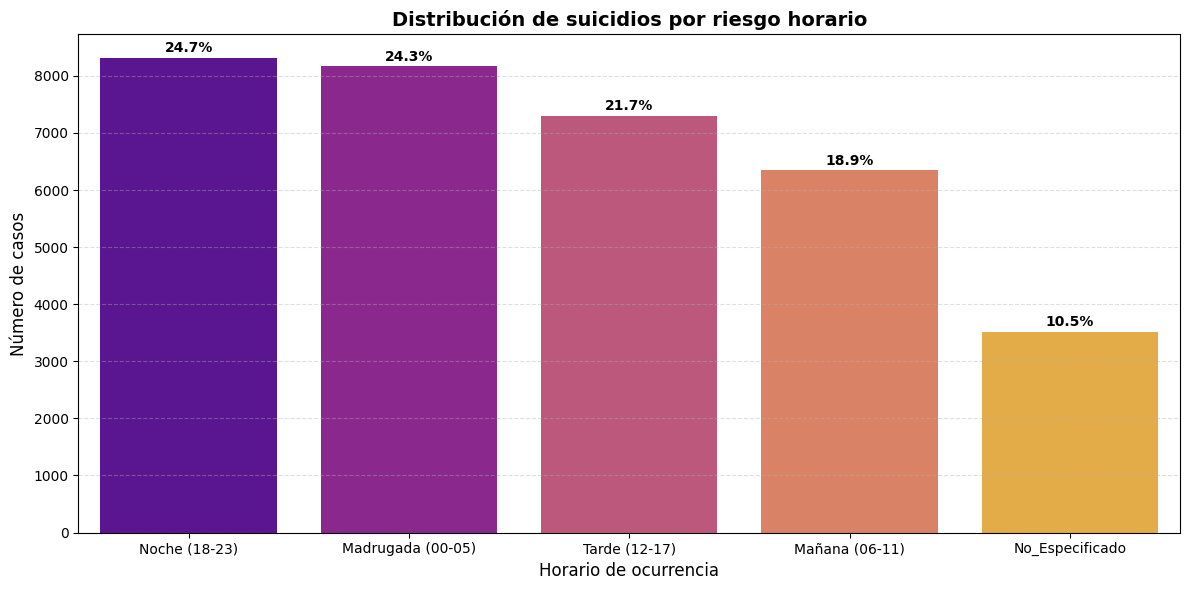

In [129]:
# Visualización
plt.figure(figsize=(12, 6))

# Generamos una paleta con 5 colores distintos
paleta_personalizada = sn.color_palette("plasma", n_colors=5)

ax = sn.barplot(
    data=conteo_ciclo, 
    x='Ciclo_Horario', 
    y='Conteo', 
    hue='Ciclo_Horario',
    palette=paleta_personalizada,
)

# Etiquetas
for index, row in conteo_ciclo.iterrows():
    ax.text(
        index, 
        row['Conteo'] + 100, 
        f"{row['Porcentaje']}%", 
        color='black', 
        ha="center",       
        fontsize=10,
        weight='bold'
    )

# Featuring
plt.title('Distribución de suicidios por riesgo horario', fontsize=14, weight='bold')
plt.xlabel('Horario de ocurrencia', fontsize=12)
plt.ylabel('Número de casos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.ylim(0, conteo_ciclo['Conteo'].max() * 1.05) 
plt.tight_layout()
plt.show()

## 03.11. Revisión de ocupación

In [130]:
cont_table_ocup = pd.crosstab(index = df_suicide['ocupacion'], columns = df_suicide['year_db'])
cont_table_ocup['Total'] = cont_table_ocup.sum(axis = 1)

In [131]:
cont_table_ocup

year_db,2020,2021,2022,2023,Total
ocupacion,,,,,
1,36,38,0,0,74
2,397,427,0,0,824
3,57,62,0,0,119
4,489,599,0,0,1088
5,236,242,0,0,478
...,...,...,...,...,...
99,300,278,0,0,578
100,0,0,1,2,3
110,0,0,2406,2547,4953


In [132]:
# Separación para reclasificación
df_2020_2021 = df_suicide[df_suicide['year_db'].isin([2020, 2021])].copy()
df_2022_2023 = df_suicide[df_suicide['year_db'].isin([2022, 2023])].copy()

print(f"Subset 2020-2021: {df_2020_2021.shape[0]}")
print(f"Subset 2022-2023: {df_2022_2023.shape[0]}")

Subset 2020-2021: 16329
Subset 2022-2023: 17313


In [133]:
# Reagrupación para 2020 y 2021
def agrupar_ocup1(code):
    if 1 <= code <= 9:
        return 'Trabaja' # Con algún tipo de trabajo
    elif code in [10, 11]: 
        return 'No_trabaja' # no trabaja o busca trabajo
    elif code in [97, 98, 99]:
        return 'No_especificado'
    else:
        # Por si nos queda algo de ruido
        return 'No_especificado'

In [134]:
# Reclasificación 2020 y 2021
df_2020_2021['ocupacion_agrup'] = df_2020_2021['ocupacion'].apply(agrupar_ocup1)

print("\nDistribución 2020-2021:")
print(df_2020_2021['ocupacion_agrup'].value_counts(normalize=True).mul(100).round(2))


Distribución 2020-2021:
ocupacion_agrup
Trabaja            48.04
No_trabaja         29.56
No_especificado    22.40
Name: proportion, dtype: float64


In [135]:
# Reagrupación para 2020 y 2021
def agrupar_ocup2(code):
    if code in [100, 110]:
        return 'No_trabaja'
    elif code in [997, 998, 999]:
        return 'No_especificado' 
    else:
        # Algún trabajo, con gran granularidad
        return 'Trabaja'

In [136]:
# Reclasificación 2020 y 2021
df_2022_2023['ocupacion_agrup'] = df_2022_2023['ocupacion'].apply(agrupar_ocup2)

print("\nDistribución 2022-2023:")
print(df_2022_2023['ocupacion_agrup'].value_counts(normalize=True).mul(100).round(2))


Distribución 2022-2023:
ocupacion_agrup
Trabaja            48.41
No_trabaja         28.63
No_especificado    22.97
Name: proportion, dtype: float64


In [137]:
# Concatenación
df_suicide_final = pd.concat([df_2020_2021, df_2022_2023])

In [138]:
# Distribución general
conteo_ocupacion = df_suicide_final['ocupacion_agrup'].value_counts().reset_index()
conteo_ocupacion.columns = ['Estatus_Laboral', 'Conteo']

conteo_ocupacion['Porcentaje'] = (conteo_ocupacion['Conteo'] / total_casos * 100).round(1)

print("\nDistribución de la ocupación:")
print(conteo_ocupacion)


Distribución de la ocupación:
   Estatus_Laboral  Conteo  Porcentaje
0          Trabaja   16225        48.2
1       No_trabaja    9783        29.1
2  No_especificado    7634        22.7


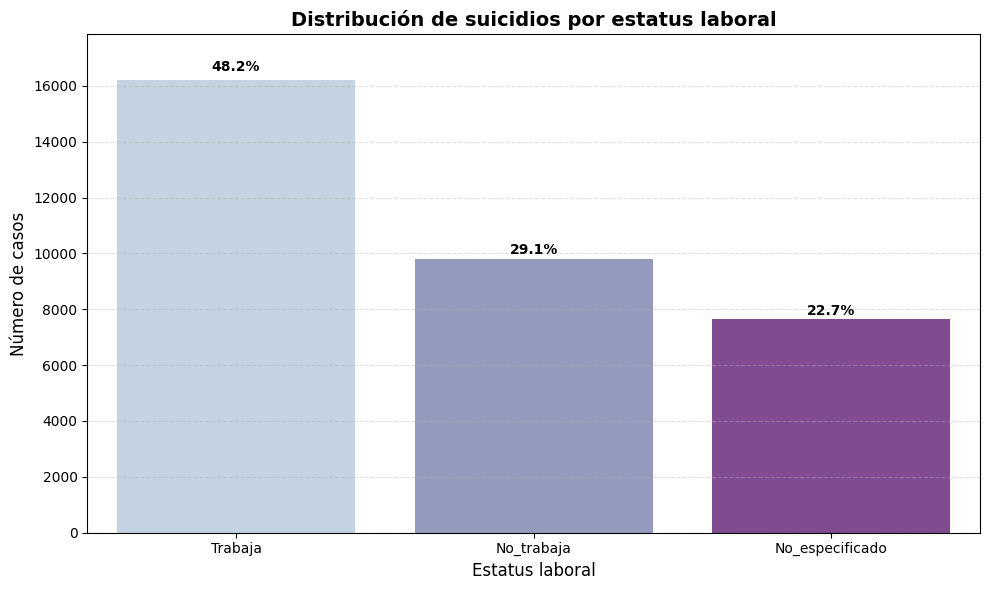

In [139]:
# Visualización
plt.figure(figsize=(10, 6))

# Reordenamiento
orden_barras = ['Trabaja', 'No_trabaja', 'No_especificado']
conteo_ocupacion['Estatus_Laboral'] = pd.Categorical(conteo_ocupacion['Estatus_Laboral'], categories=orden_barras, ordered=True)
conteo_ocupacion = conteo_ocupacion.sort_values('Estatus_Laboral') 

# Parela de colores
paleta_personalizada = sn.color_palette("BuPu", n_colors=3)

ax = sn.barplot(
    data=conteo_ocupacion, 
    x='Estatus_Laboral', 
    y='Conteo', 
    hue='Estatus_Laboral',
    palette=paleta_personalizada,
    legend=False
)

# Etiquetas
for index, row in conteo_ocupacion.iterrows():
    ax.text(
        index, 
        row['Conteo'] * 1.02, 
        f"{row['Porcentaje']}%", 
        color='black', 
        ha="center",       
        fontsize=10,
        weight='bold'
    )

# Personalización
plt.title('Distribución de suicidios por estatus laboral', fontsize=14, weight='bold')
plt.xlabel('Estatus laboral', fontsize=12)
plt.ylabel('Número de casos', fontsize=12)
plt.xticks(rotation=0, ha='center') 
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.ylim(0, conteo_ocupacion['Conteo'].max() * 1.1) 
plt.tight_layout()
plt.show()

## 03.12. Revisiones varias

In [140]:
df_suicide['tipo_defun'].value_counts() # Obviamente todos son 3: Suicidio

tipo_defun
3    33642
Name: count, dtype: int64

In [141]:
df_suicide['necropsia'].value_counts(1) # Dado que el 90% de la variable es 1:Sí y el 6% no está especificado, la variable deja de aportar valor

necropsia
1    0.915730
9    0.059331
2    0.024939
Name: proportion, dtype: float64

In [142]:
df_suicide['cond_act'].value_counts(1) # Mantendremos así la variable para evitar generar comportamientos artificiales

cond_act
1    0.666340
2    0.290619
9    0.043041
Name: proportion, dtype: float64

In [143]:
df_suicide['asist_medi'].value_counts(1) # Mantendremos así la variable para evitar generar comportamientos artificiales

asist_medi
2    0.742703
9    0.181202
1    0.076095
Name: proportion, dtype: float64

In [144]:
df_suicide['cond_cert'].value_counts(1) # Dado que el 96% de la variable es 2:médico legista, la variable deja de aportar valor

cond_cert
2    0.964449
3    0.013763
9    0.011652
1    0.005826
4    0.001813
5    0.001338
8    0.001159
Name: proportion, dtype: float64

In [145]:
df_suicide['grupo'].value_counts(1) # Por supuesto casi todos los casos son del grupo 26 que en este caso refiere a lesiones autoinfligidas 

grupo
26    0.999911
34    0.000089
Name: proportion, dtype: float64

# 04. Salida

In [146]:
df_suicide_final.columns

Index(['ent_resid', 'mun_resid', 'tloc_resid', 'loc_resid', 'ent_ocurr',
       'mun_ocurr', 'tloc_ocurr', 'loc_ocurr', 'causa_def', 'sexo', 'edad',
       'dia_ocurr', 'mes_ocurr', 'anio_ocur', 'dia_nacim', 'mes_nacim',
       'anio_nacim', 'ocupacion', 'escolarida', 'edo_civil', 'lugar_ocur',
       'necropsia', 'asist_medi', 'sitio_ocur', 'cond_cert', 'derechohab',
       'horas', 'minutos', 'grupo', 'area_ur', 'edad_agru', 'cond_act',
       'tipo_defun', 'year_db', 'age', 'fecha_nacim', 'fecha_ocurr',
       'age_manual', 'age_final', 'derechohab_agrup', 'causa_def_reduc',
       'metodo_suicidio', 'area_urbana', 'lugar_ocurrencia',
       'sitio_ocurrencia', 'escolaridad_agrup', 'hora_decimal',
       'ciclo_horario', 'ocupacion_agrup'],
      dtype='object')

In [147]:
df_suicide_final.shape

(33642, 49)

In [148]:
# Selección de columnas finales
final_columns = [
    'year_db',
    'ent_ocurr',          
    'mun_ocurr',
    'ent_resid',
    'mun_resid',
    'age_final',             
    'sexo',                  
    'edo_civil',
    'escolaridad_agrup',
    'cond_act',  
    'ocupacion_agrup', 
    'asist_medi',
    'derechohab_agrup',     
    'area_urbana',       
    'metodo_suicidio',   
    'lugar_ocurrencia',    
    'sitio_ocurrencia',
    'ciclo_horario',
    'mes_ocurr'
]

In [149]:
# DF para modelado
df_clustering = df_suicide_final[final_columns].copy()

# Salida
file_name_final = 'datos_clustering.parquet'
output_path = os.path.join(base_path, 'data_procesada')
parquet_file = os.path.join(output_path, file_name_final)
df_clustering.to_parquet(parquet_file, index=False)

In [150]:
df_clustering.columns

Index(['year_db', 'ent_ocurr', 'mun_ocurr', 'ent_resid', 'mun_resid',
       'age_final', 'sexo', 'edo_civil', 'escolaridad_agrup', 'cond_act',
       'ocupacion_agrup', 'asist_medi', 'derechohab_agrup', 'area_urbana',
       'metodo_suicidio', 'lugar_ocurrencia', 'sitio_ocurrencia',
       'ciclo_horario', 'mes_ocurr'],
      dtype='object')